In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import colorsys

In [2]:
punc = np.array([0.0026, 0.010, 0.014, 0.025, 0.042, 0.066,  0.1,   0.12,  0.17,   0.28,  0.36,  0.524, 0.61, 0.68,  0.78,  0.9, 0.96])
q = .2
V = len(punc)
vidx = np.arange(0,V)+1

In [3]:
mpl.style.use('seaborn')
map_rgb = plt.cm.rainbow(np.arange(plt.cm.RdBu.N))
map_hsv = np.ones(map_rgb.shape)
for c in range(0,map_rgb.shape[0]):
    map_hsv[c,0], map_hsv[c,1], map_hsv[c,2] = colorsys.rgb_to_hsv(map_rgb[c,0], map_rgb[c,1], map_rgb[c,2])
map_hsv[:,1] = map_hsv[:,1]*.7
map_hsv[:,2] = map_hsv[:,2]*.7
for c in range(0,map_rgb.shape[0]):
    map_rgb[c,0], map_rgb[c,1], map_rgb[c,2] = colorsys.hsv_to_rgb(map_hsv[c,0], map_hsv[c,1], map_hsv[c,2])

In [4]:
def fdr(pval, q=0.05, cV=1):
    
    if len(pval.shape) > 1:
        raise Exception('pval must be a vector')
    
    # Sort p-values
    pval  = np.sort(pval)
    oidxR = np.argsort(np.argsort(pval))

    # Number of observations
    V = len(pval);
    
    # Order (indices), in the same size as the pvalues
    idx = np.arange(V)+1
    
    # Line to be used as cutoff
    thrline = idx*q/V/cV;
    
    # Find the largest pval, still under the line
    idxthr = pval <= thrline
    if np.any(idxthr):
        
        # This is the FDR threshold
        thr = np.max(pval[idxthr])
    
        # Deal with the case when all the points under the line
        # are equal to zero, and other points are above the line
        if thr == 0:
            thr = np.max(thrline[idxthr])
    else:
        # Case when it does not cross
        thr = 0
    
    # p-corrected
    pcor = pval*V*cV/idx
    
    # p-adjusted
    padj = np.flip(np.minimum.accumulate(np.flip(pcor, axis=0)), axis=0)
    padj = padj[oidxR]
    
    # Outputs
    return thr, padj

def bky7(pval, q=0.05, cV=1):
    
    if len(pval.shape) > 1:
        raise Exception('pval must be a vector')
    
    # Sort p-values
    pval  = np.sort(pval)
    oidxR = np.argsort(np.argsort(pval))
    
    # Number of observations
    V = len(pval);
    
    # Order (indices), in the same size as the pvalues
    idx = np.arange(V)+1
    
    idxthr = np.full(idx.shape, False)
    for v in range(V):
        # Line to be used as cutoff
        thrline = idx[v:]*q/(V+1-(v+1)*(1-q))/cV
        
        # P-vals that survive the cutoff
        if np.any(pval[v:]<=thrline):
            idxthr[v] = True
        else:
            break
    
    if np.any(idxthr):
        
        # This is the FDR threshold
        thr = np.max(pval[idxthr])
    
        # Deal with the case when all the points under the line
        # are equal to zero, and other points are above the line
        if thr == 0:
            v = idx[idxthr][-1]
            thr = v*q/(V+1-v*(1-q))/cV # note here it's v, not v+1 as above, because here the indices start at 1, whereas above they start at 0
    else:
        # Case when it does not cross
        thr = 0
    
    # p-corrected
    pcor = np.ones(pval.shape);
    for v in range(V):
        # For every p-value, this is the minimum q that will eventually
        # satisfy Definition #7 of Benjamini, Krieger and Yekutieli (2006).
        pcor[v] = np.min(pval[v:]*(V+1-(v+1))*cV/(idx[v:]-(v+1)*pval[v:]));

    # p-adjusted
    #padj = np.flip(np.minimum.accumulate(np.flip(pcor, axis=0)), axis=0)
    padj = np.maximum.accumulate(pcor)
    padj = padj[oidxR]
    
    # Outputs
    return thr, padj

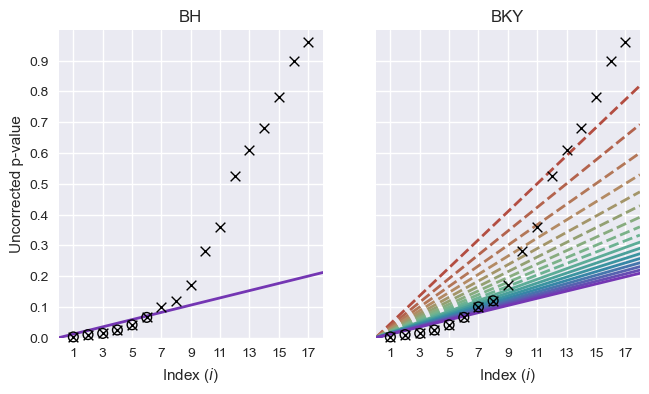

In [6]:
xidx = np.arange(0,V+2)
cV = np.sum(1/np.arange(1,V+1))
fig, ax = plt.subplots(ncols=2, nrows=1, sharex=True, sharey=True, figsize=(7.5, 4))
plt.xlim([0, V+1])
plt.ylim([0, 1])
plt.xticks(np.arange(1, V+2, step=2))
plt.yticks(np.arange(0, 1, step=0.1))

rainbow = mpl.colormaps['rainbow']._resample(V)
thr, _ = fdr(punc, q=q, cV=1)
thrline = xidx*q/V
pidx = punc <= thrline[1:-1]
ax[0].plot(xidx, thrline, zorder=1, color=map_rgb[0,:], linewidth=2, clip_on=True)
ax[0].scatter(vidx, punc, marker='x', color='black', linewidths=1, zorder=2, clip_on=False)
ax[0].scatter(vidx[punc<=thr], punc[punc<=thr], marker='o', facecolors='none', edgecolors='black', linewidths=1, zorder=3, clip_on=False)
ax[0].title.set_text('BH')
ax[0].set_xlabel('Index ($i$)')
ax[0].set_ylabel('Uncorrected p-value')

pidx = np.full(punc.shape, False)
for v in vidx:
    thrline = xidx*q/(V+1-v*(1-q))
    pidxv = punc[v-1:] <= thrline[v:-1]
    if np.any(pidxv):
        pidx[v-1] = True
        linestyle = 'solid'
    else:
        linestyle = 'dashed'
    ax[1].plot(xidx, thrline, zorder=V-v+1, color=map_rgb[int((v-1)/V*plt.cm.rainbow.N),:], linewidth=2, linestyle=linestyle, clip_on=True)
thr, _ = bky7(punc, q=q, cV=1)
ax[1].scatter(vidx, punc, marker='x', color='black', linewidths=1, zorder=V+2, clip_on=False)
ax[1].scatter(vidx[punc<=thr], punc[punc<=thr], marker='o', facecolors='none', edgecolors='black', linewidths=1, zorder=V+3, clip_on=False)
ax[1].title.set_text('BKY')
ax[1].set_xlabel('Index ($i$)')

# Save figs
fig.savefig('thresholds.svg', format='svg')
fig.savefig('thresholds.pdf', format='pdf')

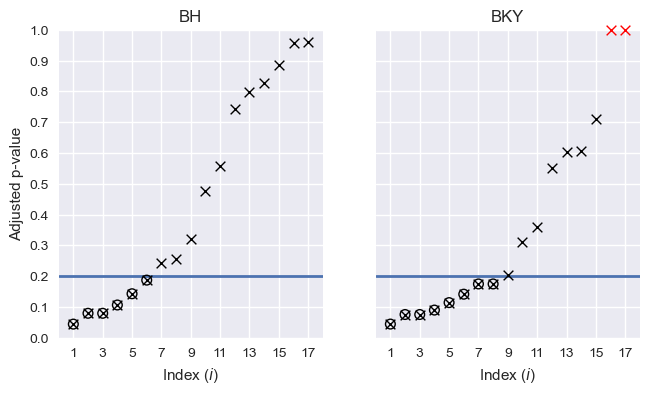

In [7]:
bhthr, bhadj       = fdr (punc, q=q, cV=1)
bhbkythr, bhbkyadj = bky7(punc, q=q, cV=1)
bhadj[bhadj>1] = 1
bhbkyadj[bhbkyadj>1] = 1

xidx = np.arange(0,V+2)
thrline = np.ones(xidx.shape)*q
fig, ax = plt.subplots(ncols=2, nrows=1, sharex=True, sharey=True, figsize=(7.5, 4))
plt.xlim([0, V+1])
plt.ylim([0, 1])
plt.xticks(np.arange(1, V+2, step=2))
plt.yticks(np.arange(0, 1.1, step=0.1))

ax[0].plot(xidx, thrline, zorder=1, linewidth=2)
ax[0].scatter(vidx[bhadj<1], bhadj[bhadj<1], marker='x', color='black', linewidths=1, zorder=2, clip_on=False)
ax[0].scatter(vidx[bhadj<=thrline[1:-1]], bhadj[bhadj<=thrline[1:-1]], marker='o', facecolors='none', edgecolors='black', linewidths=1, zorder=3, clip_on=False)
ax[0].scatter(vidx[bhadj==1], bhadj[bhadj==1], marker='x', color='red', linewidths=1, zorder=4, clip_on=False)
ax[0].title.set_text('BH')
ax[0].set_xlabel('Index ($i$)')
ax[0].set_ylabel('Adjusted p-value')

ax[1].plot(xidx, thrline, zorder=1, linewidth=2)
ax[1].scatter(vidx[bhbkyadj<1], bhbkyadj[bhbkyadj<1], marker='x', color='black', linewidths=1, zorder=2, clip_on=False)
ax[1].scatter(vidx[bhbkyadj<=thrline[1:-1]], bhbkyadj[bhbkyadj<=thrline[1:-1]], marker='o', facecolors='none', edgecolors='black', linewidths=1, zorder=3, clip_on=False)
ax[1].scatter(vidx[bhbkyadj==1], bhbkyadj[bhbkyadj==1], marker='x', color='red', linewidths=1, zorder=4, clip_on=False)
ax[1].title.set_text('BKY')
ax[1].set_xlabel('Index ($i$)')

# Save figs
fig.savefig('adjusted.svg', format='svg')
fig.savefig('adjusted.pdf', format='pdf')

In [8]:
display(bhthr, bhadj)
display(bhbkythr, bhbkyadj)

0.066

array([0.0442    , 0.07933333, 0.07933333, 0.10625   , 0.1428    ,
       0.187     , 0.24285714, 0.255     , 0.32111111, 0.476     ,
       0.55636364, 0.74233333, 0.79769231, 0.82571429, 0.884     ,
       0.95625   , 0.96      ])

0.12

array([0.04431522, 0.07537012, 0.07537012, 0.08974359, 0.11398747,
       0.14132762, 0.17460317, 0.17460317, 0.20481928, 0.31111111,
       0.35795455, 0.55042017, 0.60157791, 0.60714286, 0.70909091,
       1.        , 1.        ])